##Data Entry:

In [ ]:
#imports
import requests as req
import torch
import pandas as pd
import yfinance as yf
import json
from typing import Any, Dict
import os

In [ ]:
stock_symbol = input('Please enter a stock symbol: ')

Please enter a stock symbol: AAPL


In [ ]:
#Technical API
data_tech = yf.download(stock_symbol, start='2024-04-01', end='2024-10-26')
data_tech.head()

[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,,
2024-04-01 00:00:00+00:00,169.603378,170.029999,171.250000,169.479996,171.190002,46240500
2024-04-02 00:00:00+00:00,168.416351,168.839996,169.339996,168.229996,169.080002,49329500
2024-04-03 00:00:00+00:00,169.224319,169.649994,170.679993,168.580002,168.789993,47691700
2024-04-04 00:00:00+00:00,168.396423,168.820007,171.919998,168.820007,170.289993,53704400
2024-04-05 00:00:00+00:00,169.154495,169.580002,170.389999,168.949997,169.589996,42055200


In [458]:
import requests as req
import torch
import pandas as pd
import yfinance as yf
import json
from typing import Any, Dict
import os
# Your API key
api_key = '34488U3HVRMD3BHQ'


def get_news_sentiment(symbol: str, api_key: str) -> Dict[str, Any]:
    url_news = f'https://www.alphavantage.co/query?function=NEWS_SENTIMENT&symbol={symbol}&apikey={api_key}'
    response_news = req.get(url_news)
    return response_news.json()

def clean_and_format_data(data: Dict[str, Any]) -> Dict[str, Any]:
    # Clean the metadata
    metadata = {
        "items": int(data.get('items', 0)),
        "sentiment_score_definition": {
            "Bearish": "x <= -0.35",
            "Somewhat_Bearish": "-0.35 < x <= -0.15",
            "Neutral": "-0.15 < x < 0.15",
            "Somewhat_Bullish": "0.15 <= x < 0.35",
            "Bullish": "x >= 0.35"
        },
        "relevance_score_definition": data.get('relevance_score_definition', '')
    }

    # Function to format the publication time
    def format_time(time_str: str) -> str:
        return f"{time_str[:4]}-{time_str[4:6]}-{time_str[6:8]}T{time_str[8:10]}:{time_str[10:12]}:00Z"

    # Clean the feed items
    feed = []
    for item in data.get('feed', []):
        cleaned_article = {
            "title": item.get('title', ''),
            "url": item.get('url', ''),
            "time_published": format_time(item.get('time_published', '')),
            "authors": item.get('authors', []),
            "summary": item.get('summary', ''),
            "banner_image": item.get('banner_image', ''),
            "source": item.get('source', ''),
            "category_within_source": item.get('category_within_source', 'n/a'),
            "source_domain": item.get('source_domain', ''),
            "topics": [
                {
                    "topic": topic.get('topic', ''),
                    "relevance_score": float(topic.get('relevance_score', 0))
                } for topic in item.get('topics', [])
            ],
            "overall_sentiment_score": item.get('overall_sentiment_score', 0.0),
            "overall_sentiment_label": item.get('overall_sentiment_label', ''),
            "ticker_sentiment": [
                {
                    "ticker": ticker.get('ticker', ''),
                    "relevance_score": float(ticker.get('relevance_score', 0)),
                    "ticker_sentiment_score": float(ticker.get('ticker_sentiment_score', 0)),
                    "ticker_sentiment_label": ticker.get('ticker_sentiment_label', '')
                } for ticker in item.get('ticker_sentiment', [])
            ]
        }
        feed.append(cleaned_article)

    return {
        "metadata": metadata,
        "feed": feed
    }

cleaned_data = clean_and_format_data(news_data)

# # Print cleaned data
# print(json.dumps(cleaned_data, indent=4))


def extract_ticker_data(cleaned_data: Dict[str, Any], ticker_symbol: str) -> List[Dict[str, Any]]:
    # Get the feed array which contains all articles
    feed = cleaned_data.get('feed', [])

    ticker_data_list = []

    # Loop through each article in the feed
    for article in feed:
        ticker_sentiments = article.get('ticker_sentiment', [])

        # Look for the specified ticker in each article's ticker sentiments
        for ticker_data in ticker_sentiments:
            if ticker_data.get('ticker') == ticker_symbol:
                ticker_data_list.append({
                    'title': article.get('title'),
                    'time_published': article.get('time_published'),
                    'ticker_data': ticker_data
                })
                break  # Found the ticker in this article, move to next article

    return ticker_data_list

# Specify the stock symbol you want to analyze (e.g., Apple Inc. - AAPL)
ticker_symbol = input("Enter ticker symbol: ")

# Get the news sentiment data
data = get_news_sentiment(ticker_symbol, api_key)

# Clean the data
cleaned_data = clean_and_format_data(data)

# Print cleaned data and sentiment scores
#print("Cleaned Data:")
#print(json.dumps(cleaned_data, indent=4))

ticker_data = extract_ticker_data(cleaned_data, ticker_symbol)
if ticker_data:
    #print(f"\nFound {len(ticker_data)} articles mentioning {ticker_symbol}:")

    sentiment_scores = []

    for item in ticker_data:
        score = item['ticker_data']['ticker_sentiment_score']
        sentiment_scores.append(score)
        #print(f"Ticker Sentiment Score: {score}")

    # Calculate the average sentiment score
    if sentiment_scores:
        average_sentiment_score = 100*(sum(sentiment_scores) / len(sentiment_scores))
        print(f"\nAverage Ticker Sentiment Score: {average_sentiment_score:.4f}")
else:
    print(f"\nNo data found for ticker {ticker_symbol}.")


Enter ticker symbol: AAPL

Average Ticker Sentiment Score: 13.6362


##Data Preprocessing

In [ ]:
#Technical
data_tech.columns = data_tech.columns.droplevel('Ticker')
data_tech.index

DatetimeIndex(['2024-04-01 00:00:00+00:00', '2024-04-02 00:00:00+00:00',
               '2024-04-03 00:00:00+00:00', '2024-04-04 00:00:00+00:00',
               '2024-04-05 00:00:00+00:00', '2024-04-08 00:00:00+00:00',
               '2024-04-09 00:00:00+00:00', '2024-04-10 00:00:00+00:00',
               '2024-04-11 00:00:00+00:00', '2024-04-12 00:00:00+00:00',
               ...
               '2024-10-14 00:00:00+00:00', '2024-10-15 00:00:00+00:00',
               '2024-10-16 00:00:00+00:00', '2024-10-17 00:00:00+00:00',
               '2024-10-18 00:00:00+00:00', '2024-10-21 00:00:00+00:00',
               '2024-10-22 00:00:00+00:00', '2024-10-23 00:00:00+00:00',
               '2024-10-24 00:00:00+00:00', '2024-10-25 00:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='Date', length=146, freq=None)

In [ ]:
#Get Target value

data_tech = data_tech[['Adj Close']]
data_tech.head()

Price,Adj Close
Date,
2024-04-01 00:00:00+00:00,169.603378
2024-04-02 00:00:00+00:00,168.416351
2024-04-03 00:00:00+00:00,169.224319
2024-04-04 00:00:00+00:00,168.396423
2024-04-05 00:00:00+00:00,169.154495


In [ ]:
#Prepare data for LSTM
from copy import deepcopy as dc
def prepare_df_LSTM(df, n_days):
  #Innit df
  df = dc(df)
  #Create columns for LSTM data (one week)
  for i in range(1, n_days+1):
    df['Target (T - {})'.format(i)] = df['Adj Close'].shift(i)

  #Remove na values
  df.dropna(inplace = True)

  return df

n_days = 7
LSTM_df = prepare_df_LSTM(data_tech, n_days)
print(LSTM_df)

#Switch into NumPy Array
LSTM_df = LSTM_df.to_numpy()

Price                       Adj Close  Target (T - 1)  Target (T - 2)  \
Date                                                                    
2024-04-10 00:00:00+00:00  167.359024      169.244278      168.027344   
2024-04-11 00:00:00+00:00  174.600800      167.359024      169.244278   
2024-04-12 00:00:00+00:00  176.107025      174.600800      167.359024   
2024-04-15 00:00:00+00:00  172.256699      176.107025      174.600800   
2024-04-16 00:00:00+00:00  168.955017      172.256699      176.107025   
...                               ...             ...             ...   
2024-10-21 00:00:00+00:00  236.479996      235.000000      232.149994   
2024-10-22 00:00:00+00:00  235.860001      236.479996      235.000000   
2024-10-23 00:00:00+00:00  230.759995      235.860001      236.479996   
2024-10-24 00:00:00+00:00  230.570007      230.759995      235.860001   
2024-10-25 00:00:00+00:00  231.410004      230.570007      230.759995   

Price                      Target (T - 3)  Target 

In [ ]:
#Normalize data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data_normalized = scaler.fit_transform(LSTM_df)

In [ ]:
#Split the data
X = data_normalized[:, 1:]
Y = data_normalized[:, 0]

Split = int(len(X) * 0.85)

X_train = X[:Split]
X_test = X[Split:]
Y_train = Y[:Split]
Y_test = Y[Split:]

In [ ]:
#PyTorch
import torch
import torch.nn as nn
import torch.optim as optim

X_train = torch.tensor(X_train, dtype = torch.float)
X_test = torch.tensor(X_test, dtype = torch.float)
Y_train = torch.tensor(Y_train, dtype = torch.float)
Y_test = torch.tensor(Y_test, dtype = torch.float)

In [ ]:
#Model
class LSTM_Model(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(LSTM_Model, self).__init__()
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Convert DataFrame to tensor and ensure it's correctly shaped
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x.values, dtype=torch.float32)
        x = x.unsqueeze(0)  # Add a batch dimension if missing

        # Move tensor to appropriate device
        device = x.device
        x = x.to(device)

        # Initialize hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(device)

        # Forward propagate LSTM
        out, (hn, cn) = self.lstm(x, (h0, c0))

        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out


In [ ]:
model = LSTM_Model(input_dim=7, hidden_dim=32, output_dim=1, num_layers=1)


In [ ]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)

In [ ]:
#Grad descent
epochs = 2000

for epoch in range(epochs):
  outputs = model(X_train)
  loss = criterion(outputs , Y_train)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  if (epoch + 1) % 100 == 0:
      print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')



/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([118])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [100/2000], Loss: 0.3775
Epoch [200/2000], Loss: 0.3559
Epoch [300/2000], Loss: 0.3352
Epoch [400/2000], Loss: 0.3153
Epoch [500/2000], Loss: 0.2958
Epoch [600/2000], Loss: 0.2766
Epoch [700/2000], Loss: 0.2577
Epoch [800/2000], Loss: 0.2388
Epoch [900/2000], Loss: 0.2199
Epoch [1000/2000], Loss: 0.2011
Epoch [1100/2000], Loss: 0.1824
Epoch [1200/2000], Loss: 0.1641
Epoch [1300/2000], Loss: 0.1464
Epoch [1400/2000], Loss: 0.1299
Epoch [1500/2000], Loss: 0.1152
Epoch [1600/2000], Loss: 0.1031
Epoch [1700/2000], Loss: 0.0942
Epoch [1800/2000], Loss: 0.0885
Epoch [1900/2000], Loss: 0.0855
Epoch [2000/2000], Loss: 0.0842


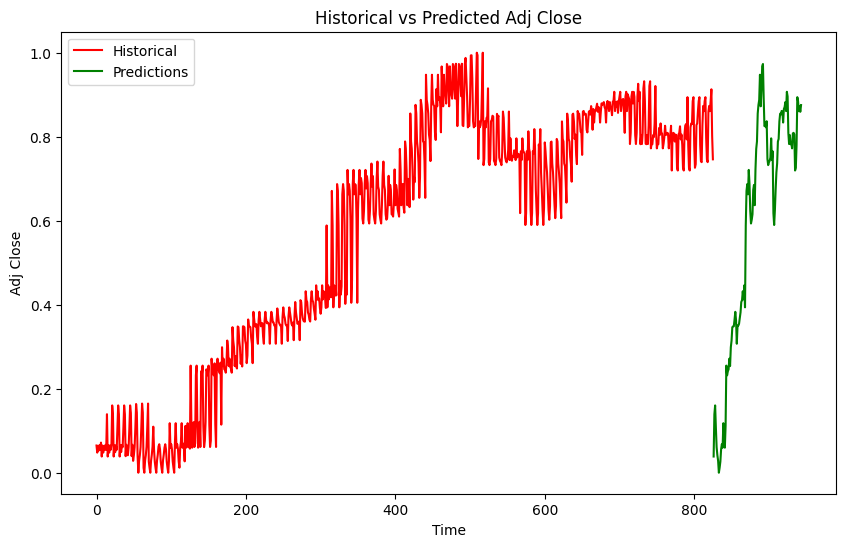

In [ ]:
#Prep for Graph
import matplotlib.pyplot as plt
predict = pd.DataFrame(Y_train.detach().numpy().reshape(-1, 1), columns=['Scaled_Predicted'])
original = pd.DataFrame((X_train.detach().numpy().reshape(-1, 1)))
#Graph the data
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
xa = list(range(len(original)))
ax.plot(xa, original, color='red', label='Historical')
xb = list(range(len(original), len(original) + len(predict)))
ax.plot(xb, predict, color='green', label='Predictions')
ax.set_xlabel('Time')
ax.set_ylabel('Adj Close')
ax.set_title('Historical vs Predicted Adj Close')
ax.legend()
plt.show()

In [ ]:
import numpy as np
def Number_Gen(array):
    """
    Maps a scaled NumPy array (values between 0 and 1) to a 1-100 scale:
    - 1-49: Stock is going down (lower values indicate stronger downward movement)
    - 50: Stock remains the same (neutral)
    - 51-100: Stock is going up (higher values indicate stronger upward movement)

    Parameters:
    - array (np.ndarray): Scaled array with values between 0 and 1.

    Returns:
    - np.ndarray: Mapped array with values between 1 and 100.
    """
    # Ensure the input is a NumPy array
    array = np.array(array)

    # Initialize the mapped array with zeros
    mapped_array = np.zeros_like(array, dtype=int)

    # Define masks for different conditions
    mask_down = array < 0.5
    mask_neutral = array == 0.5
    mask_up = array > 0.5

    # Mapping for 'Down' (1-49)
    # Scale 0 to 0.5 → 1 to 49
    # Formula: ((value / 0.5) * 48) + 1
    mapped_array[mask_down] = np.round((array[mask_down] / 0.5) * 48 + 1).astype(int)

    # Mapping for 'Neutral' (50)
    mapped_array[mask_neutral] = 50

    # Mapping for 'Up' (51-100)
    # Scale 0.5 to 1 → 51 to 100
    # Formula: (((value - 0.5) / 0.5) * 49) + 51
    mapped_array[mask_up] = np.round(((array[mask_up] - 0.5) / 0.5) * 49 + 51).astype(int)

    # Ensure all values are within 1-100
    mapped_array = np.clip(mapped_array, 1, 100)

    return mapped_array

In [453]:
Number = Number_Gen(predict)
print(Number)

[[ 5]
 [14]
 [16]
 [11]
 [ 7]
 [ 5]
 [ 4]
 [ 1]
 [ 2]
 [ 4]
 [ 6]
 [ 8]
 [ 7]
 [12]
 [ 8]
 [ 7]
 [12]
 [25]
 [23]
 [24]
 [25]
 [27]
 [25]
 [30]
 [31]
 [34]
 [34]
 [34]
 [36]
 [38]
 [36]
 [30]
 [35]
 [35]
 [35]
 [36]
 [38]
 [40]
 [40]
 [42]
 [41]
 [44]
 [39]
 [60]
 [68]
 [69]
 [67]
 [73]
 [69]
 [63]
 [60]
 [61]
 [62]
 [68]
 [69]
 [64]
 [73]
 [78]
 [79]
 [86]
 [88]
 [89]
 [95]
 [87]
 [92]
 [97]
 [97]
 [89]
 [83]
 [83]
 [83]
 [84]
 [75]
 [74]
 [74]
 [75]
 [76]
 [80]
 [75]
 [77]
 [63]
 [60]
 [63]
 [68]
 [72]
 [74]
 [79]
 [80]
 [84]
 [86]
 [86]
 [86]
 [86]
 [84]
 [87]
 [87]
 [88]
 [86]
 [91]
 [90]
 [81]
 [79]
 [81]
 [79]
 [79]
 [78]
 [81]
 [81]
 [81]
 [73]
 [73]
 [78]
 [90]
 [89]
 [86]
 [88]
 [86]
 [88]]


In [464]:
Score_Tech = Number.mean()
print(Score_Tech)
print(average_sentiment_score)

58.63559322033898
13.6362


In [466]:
Total_Score = (average_sentiment_score + Score_Tech) / 2
print(Total_Score)

36.13589661016949
